Solve this exercise by using the demo notebook: Getting_Started_with_a_Movie_Recommendation_System.ipynb

Full path to the dataset: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews?select=Books_rating.csv

In [1]:
# Load packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import kagglehub

from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

/home/atvars/miniconda3/envs/aai_recom_sys/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Download the data

In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
data_path = kagglehub.dataset_download(handle="mohamedbakhet/amazon-books-reviews")

print('Data source import complete.')

Data source import complete.


# Import the data

In [3]:
#Load the dataframes
df_ratings = pd.read_csv(os.path.join(data_path, 'Books_rating.csv'))
df_bookinfo = pd.read_csv(os.path.join(data_path, 'books_data.csv'))

Describe the content of both dataframes

In [4]:
# Print first five rows of df_ratings
df_ratings.head(5)

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


### Ratings Df Rows:

Id
- ID of the reviewed book

Title
- Title of the book

Price
- Price of the book

User_id
- ID of the user that gave the review

profileName
- Profile name of the user that gave the review

review/helpfulness
- Amazon has a feature to mark a review as helpful or unhelpful. For example, 7/7 means 7 out of 7 people found this helpful. 10/11 means ten out of eleven people found this helpful.

review/score
- Rating of the review (out of 5)

review/time
- Time of the review (Unix time)

review/summary
- Brief summary of the review

review/text
- Full body of the review

In [5]:
# Print first five rows of df_bookinfo
df_bookinfo.head(5)

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN


Title
- Title of the book

description
- Description of the book

authors
- List of authors for the book

image
- Link to cover image of the book

previewLink
- Link to a small preview of the book, which can be accessed for free

publisher
- Publisher of the book

publishedDate
- Date that the book was released

infoLink
- Link to get more information about the book

categories
- Genres of the book

ratingsCount
- Number or reviews for the book

# Process the data

In [6]:
# We need the vote_count and vote_average to calculate the metric below. We will calculate these with df_ratings
# In df_ratings, calculate the vote average and vote count per book based on review/score column
grouped_ratings_df = df_ratings.groupby('Title').agg(
    vote_average=('review/score', 'mean'),
    vote_count=('review/score', 'count')
).reset_index()

In [7]:
grouped_ratings_df.head(5)

,Title,vote_average,vote_count
0,""" Film technique, "" and, "" Film acting """,4.500,2
1,""" We'll Always Have Paris"": The Definitive Gui...",5.000,2
2,"""... And Poetry is Born ..."" Russian Classical...",4.000,1
3,"""A Titanic hero"" Thomas Andrews, shipbuilder",4.875,8
4,"""A Truthful Impression of the Country"": Britis...",4.000,1


In [8]:
# Merge df_bookinfo with vote_count and vote_average
merged_bookinfo = pd.merge(df_bookinfo, grouped_ratings_df, how='left', left_on="Title", right_on='Title')

In [9]:
# Select the first 20000 books, otherwise it will be difficult to do the calculations below with your RAM
bookinfo_slice = merged_bookinfo.iloc[:20000, :].copy()
bookinfo_slice.shape

(20000, 12)

# **Demographic Filtering** -
   Before getting started with this  -
* we need a metric to score or rate a book
* Calculate the score for every book
* Sort the scores and recommend the best rated book to the users.

We can use the average ratings of the book as the score but using this won't be fair enough since a book with 4.5 average rating and only 3 votes cannot be considered better than the book with 3.9 as as average rating but 40 votes.
So, I'll be using IMDB's weighted rating (wr) which is given as :-

![](https://image.ibb.co/jYWZp9/wr.png)
where,
* v is the number of votes for the movie;
* m is the minimum votes required to be listed in the chart;
* R is the average rating of the movie; And
* C is the mean vote across the whole report

Now apply this on the books dataset instead of on movies.

We already have v(**vote_count**) and R (**vote_average**) and C can be calculated as

In [10]:
# Calculate C
C = bookinfo_slice['vote_average'].mean()
C

4.262029678317345

So, the mean rating for all the books is approx 4.3 on a scale of 5.The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 90th percentile as our cutoff. In other words, for a book to feature in the charts, it must have more votes than at least 90% of the book in the list.

In [11]:
# calculate m
m = bookinfo_slice['vote_count'].quantile(0.9)
m

24.0

Now, we can filter out the books that qualify for the chart

In [12]:
# filter out the books that qualify for the chart
q_books = bookinfo_slice.copy().loc[bookinfo_slice['vote_count'] >= m]
q_books.shape

(2025, 12)

We see that there are 2025 books which qualify to be in this list. Now, we need to calculate our metric for each qualified book. To do this, we will define a function, **weighted_rating()** and define a new feature **score**, of which we'll calculate the value by applying this function to our DataFrame of qualified books:

In [13]:
# Construct a weighted_rating function that calculates the metric for each qualified book
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [14]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_books['score'] = q_books.apply(weighted_rating, axis=1)

Finally, let's sort the DataFrame based on the score feature and output the title, vote count, vote average and weighted rating or score of the top 10 books.

In [15]:
#Sort books based on score calculated above and print the top 10 books
#Sort books based on score calculated above
q_books = q_books.sort_values('score', ascending=False)

#Print the top 10 books
q_books[['Title', 'vote_count', 'vote_average', 'score']].head(10)

,Title,vote_count,vote_average,score
4991,Betty Crocker's cooky book,233.0,4.909871,4.849372
9718,Little Britches,192.0,4.916667,4.843929
19151,The Valley of Vision: a Collection of Puritan ...,179.0,4.921788,4.843787
11988,Mossflower,313.0,4.872204,4.828750
15230,The Synonym Finder,307.0,4.863192,4.819603
4671,Angelique: The Marquise of the Angels,87.0,4.954023,4.804403
13706,The Family Nobody Wanted,140.0,4.885714,4.794443
12227,Anne of the Island,249.0,4.843373,4.792266
16334,"The Happy Hollisters (The Happy Hollisters, No...",107.0,4.906542,4.788463
12044,"Why revival tarries,",69.0,4.971014,4.788051


Hurray! We have made our first(though very basic) recommender.
Under the **Trending Now** tab of these systems we find books that are very popular and they can just be obtained by sorting the dataset by the popularity column.

In [16]:
last_month_ratings = df_ratings[df_ratings['review/time'] < (df_ratings['review/time'].max() - 30*24*60*60)]
last_month_ratings = last_month_ratings['Title'].value_counts()

In [17]:
# Print the five most popular books based on the review/time column in df_ratings. Take all reviews into account of the last month in the dataset.
last_month_ratings = last_month_ratings.reset_index()
last_month_ratings.head()

,Title,count
0,The Hobbit,20252
1,Pride and Prejudice,18603
2,Atlas Shrugged,12324
3,Wuthering Heights,10200
4,The Giver,7526


In [18]:
# Head of the merged dataframe
top_books_df = pd.merge(last_month_ratings, q_books, how='left', left_on='Title', right_on='Title')

Text(0.5, 1.0, 'Popular Books')

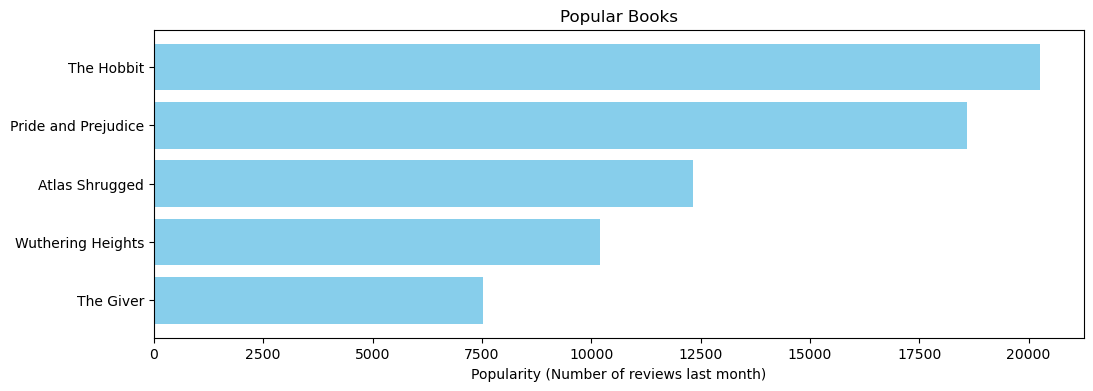

In [19]:
# Make a bar plot of the 5 most popular books
pop = top_books_df
plt.figure(figsize=(12,4))

plt.barh(pop['Title'].head(5),pop['count'].head(5), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity (Number of reviews last month)")
plt.title("Popular Books")

Now something to keep in mind is that these demographic recommender provide a general chart of recommended books to all the users. They are not sensitive to the interests and tastes of a particular user.
This is when we move on to a more refined system-  Content Based Filtering.

# **Content Based Filtering**
In this recommender system the content of the book is used to find its similarity with other books. Then the books that are most likely to be similar are recommended.

## **Plot description based Recommender**

We will compute pairwise similarity scores for all books based on their plot descriptions and recommend books based on that similarity score. The plot description is given in the **overview** feature of our dataset.
Let's take a look at the data. ..

In [20]:
# Display the first five rows of the 'description' column in bookinfo
bookinfo_slice['description'].head(5)

0                                                  NaN
1    Philip Nel takes a fascinating look into the k...
2    This resource includes twelve principles in un...
3    Julia Thomas finds her life spinning out of co...
4                                                  NaN
Name: description, dtype: object

For any of you who has done even a  bit of text processing before knows we need to convert the word vector of each overview.
Now we'll compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview.

Now if you are wondering what is term frequency , it is the relative frequency of a word in a document and is given as
   **(term instances/total instances)**.
Inverse Document Frequency is the relative count of documents containing the term is given as
**log(number of documents/documents with term)**
The overall importance of each word to the documents in which they appear is equal to **TF * IDF**

This will give you a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document) and each row represents a book, as before.This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.

Fortunately, scikit-learn gives you a built-in TfIdfVectorizer class that produces the TF-IDF matrix in a couple of lines. That's great, isn't it?

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
bookinfo_slice['description'] = bookinfo_slice['description'].fillna('')

tfidf_matrix = tfidf.fit_transform(bookinfo_slice['description'])

tfidf_matrix.shape

(20000, 68745)

We see that over 68000 different words were used to describe the more than 20000 selected books in our dataset.

With this matrix in hand, we can now compute a similarity score. There are several candidates for this; such as the euclidean, the Pearson and the [cosine similarity scores](https://en.wikipedia.org/wiki/Cosine_similarity). There is no right answer to which score is the best. Different scores work well in different scenarios and it is often a good idea to experiment with different metrics.

We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two books. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:
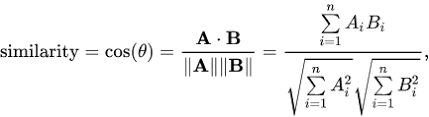

Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's **linear_kernel()** instead of cosine_similarities() since it is faster.

In [23]:
# Compute the cosine similarity matrix
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

We are going to define a function that takes in a book title as an input and outputs a list of the 10 most similar books. Firstly, for this, we need a reverse mapping of book titles and DataFrame indices. In other words, we need a mechanism to identify the index of a book in our metadata DataFrame, given its title.

In [24]:
#Construct a reverse map of indices and book titles
indices = pd.Series(bookinfo_slice.index, index=bookinfo_slice['Title']).drop_duplicates()

We are now in a good position to define our recommendation function. These are the following steps we'll follow :-
* Get the index of the book given its title.
* Get the list of cosine similarity scores for that particular book with all books. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
* Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
* Get the top 10 elements of this list. Ignore the first element as it refers to self (the book most similar to a particular book is the book itself).
* Return the titles corresponding to the indices of the top elements.

In [25]:
# Function that takes in book title as input and outputs most similar books
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return bookinfo_slice['Title'].iloc[movie_indices]

In [26]:
get_recommendations('The Battleship Bismarck', cosine_sim)

18403                   The last nine days of the Bismarck
6850                                 Admirals in Collision
17239    Band of Brothers: Boy Seamen in the Royal Navy...
6134     Sharpe's Trafalgar (Richard Sharpe's Adventure...
9558                            Cunard: 150 Glorious Years
8111                 The Letter of Marque (Aubrey-Maturin)
14326                                      Distant Gunfire
476                 United States Navy Aircraft Since 1911
10194           Germany's high sea fleet in the world war,
14765                                    Captain Kilburnie
Name: Title, dtype: object

In [27]:
get_recommendations('Wonderful Worship in Smaller Churches', cosine_sim)

17661    Classic Children's Prayers (Little Prayer Series)
3919     The Ultimate Priority: John Macarthur, Jr. on ...
13468    For the Audience of One: Worshiping the One an...
13873              Psalms In Worship, The (Lillenas Drama)
3231     The Worship Leader's Handbook: Practical Answe...
7927     When We Gather, Revised Edition: A Book of Pra...
10187                         The Cokesbury Worship Hymnal
9911     Whatever Happened to Worship: A Call To True W...
16143                                            Catholics
14378                                   As It Is in Heaven
Name: Title, dtype: object

## **Authors, publisher, published date and Genres Based Recommender**
It goes without saying that the quality of our recommender would be increased with the usage of better metadata. That is exactly what we are going to do in this section. We are going to build a recommender based on the following metadata: the authors, the publisher, the published date and related genres.

We need to convert the data into safe and useable features first.
* Authors and categories are a list of strings -> convert stringified list to a list
* Publisher is a string -> ok
* published date is a date -> this has to be converted to a float and normalised

In [28]:
# Convert stringified list to a list

# Library needed to convert stringified list to a list
from ast import literal_eval

In [29]:
# First, fill the NaN values with an empty string
bookinfo_slice['authors'] = bookinfo_slice['authors'].fillna('[]')
# Now, convert the stringified list to a list
bookinfo_slice['authors'] = bookinfo_slice['authors'].apply(literal_eval)
# Check whether the conversion was successful
print(type(bookinfo_slice['authors'][0]))

<class 'list'>


In [30]:
# Same but for the 'categories' column
bookinfo_slice['categories'] = bookinfo_slice['categories'].fillna('[]')
bookinfo_slice['categories'] = bookinfo_slice['categories'].apply(literal_eval)
print(type(bookinfo_slice['categories'][0]))

<class 'list'>


In [31]:
# Convert all values in publishedDate to a string of the year. Some entries are in 'year' format, some in 'year-month-day' format
# If values are Nan, return Nan
bookinfo_slice['publishedDate'] = bookinfo_slice['publishedDate'].apply(lambda x: str(x).split('-')[0] if pd.notnull(x) else x)

In [32]:
# Print the new features of the first 5 books
bookinfo_slice[['Title', 'authors', 'categories', 'publishedDate']].head(5)

,Title,authors,categories,publishedDate
0,Its Only Art If Its Well Hung!,[Julie Strain],[Comics & Graphic Novels],1996
1,Dr. Seuss: American Icon,[Philip Nel],[Biography & Autobiography],2005
2,Wonderful Worship in Smaller Churches,[David R. Ray],[Religion],2000
3,Whispers of the Wicked Saints,[Veronica Haddon],[Fiction],2005
4,"Nation Dance: Religion, Identity and Cultural ...",[Edward Long],[],2003


The next step would be to convert the names and keyword instances into lowercase and strip all the spaces between them. This is done so that our vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same.

In [33]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [34]:
# Apply clean_data function to your features.
features = ['authors', 'categories', 'publishedDate', 'publisher']

for feature in features:
    bookinfo_slice[feature] = bookinfo_slice[feature].apply(clean_data)

We are now in a position to create our "metadata soup", which is a string that contains all the metadata that we want to feed to our vectorizer.

In [35]:
# Create a metadata soup using the function seen in the demo
def create_soup(x):
    return ' '.join(x['authors']) + ' ' + ' '.join(x['categories']) + ' ' + x['publishedDate'] + ' ' + ' '.join(x['publisher'])

bookinfo_slice['soup'] = bookinfo_slice.apply(create_soup, axis=1)

The next steps are the same as what we did with our plot description based recommender. One important difference is that we use the **CountVectorizer()** instead of TF-IDF. This is because we do not want to down-weight the presence of for example an author if he or she has written more books. It doesn't make much intuitive sense.

In [36]:
# Create the count matrix
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(bookinfo_slice['soup'])

<div style="border: 2px solid red; padding: 10px; background-color:rgb(216, 233, 142); color: red; font-weight: bold; font-size: 16px;">
⚠️ **WARNING:** When I fitted the Count Vectorizer to my *whole* dataset, my computer ran out of RAM, so I had to fit it to the slice of the book info dataset that I created earlier.
</div>

In [37]:
# Compute the Cosine Similarity matrix based on the count_matrix
cosine_sim_bookinfo_description = cosine_similarity(count_matrix, count_matrix)

In [38]:
# Reset index of our main DataFrame and construct reverse mapping as before
bookinfo_slice = bookinfo_slice.reset_index()
indices = pd.Series(bookinfo_slice.index, index=bookinfo_slice['Title'])

We can now reuse our **get_recommendations()** function by passing in the new **cosine_sim2** matrix as your second argument.

In [39]:
get_recommendations('The Battleship Bismarck', cosine_sim_bookinfo_description)

14                                    A husband for Kutani
656      Crusade of the Left: The Lincoln battalion in ...
2076     Snorri Sturluson: Ein biografi (Norwegian Edit...
3732              Spirit Song: The Introduction of No-Eyes
4218     Queen of France;: A biography of Marie Antoinette
5936     Growth in holiness; or, The progress of the sp...
7751              The complete memoirs of George Sherston,
9063                              England Under The Tudors
12110    A German Ace Tells Why: From Kaiserdom to Hitl...
12166    A History of Russia, Central Asia and Mongolia...
Name: Title, dtype: object

In [40]:
get_recommendations('Wonderful Worship in Smaller Churches', cosine_sim_bookinfo_description)

1547     A Philadelphia Catholic to King James's Court:...
1731     Searching for an Adequate God: A Dialogue betw...
2396     My Soul Thirsts: An Invitation to Intimacy Wit...
5001                    Word pictures in the New Testament
6500     And I Will Dwell in Their Midst: Orthodox Jews...
7060        Raw Faith: Nurturing the Believer in All of Us
9707     Journey to Self-Realization - Collected Talks ...
10545                           Reconstructing Catholicism
13182                                            The Koran
13274    Directions for Communication Discoveries with ...
Name: Title, dtype: object

On first glance, the recommendations look trustworthy. But it is difficult to see whether these recommendations are better than the ones with the first cosine_sim. We need the test methods described in the theory to check this.

# **Collaborative Filtering**

Our content based engine suffers from some severe limitations. It is only capable of suggesting books which are close to a certain book. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a book will receive the same recommendations for that book, regardless of who she/he is.

Therefore, in this section, we will use a technique called Collaborative Filtering to make recommendations to book Watchers.
It is basically of two types:-

*  **User based filtering**-  These systems recommend products to a user that similar users have liked. For measuring the similarity between two users we can either use pearson correlation or cosine similarity.
This filtering technique can be illustrated with an example. In the following matrixes, each row represents a user, while the columns correspond to different books except the last one which records the similarity between that user and the target user. Each cell represents the rating that the user gives to that book. Assume user E is the target.
![](https://cdn-images-1.medium.com/max/1000/1*9NBFo4AUQABKfoUOpE3F8Q.png)

Since user A and F do not share any book ratings in common with user E, their similarities with user E are not defined in Pearson Correlation. Therefore, we only need to consider user B, C, and D. Based on Pearson Correlation, we can compute the following similarity.
![](https://cdn-images-1.medium.com/max/1000/1*jZIMJzKM1hKTFftHfcSxRw.png)

From the above table we can see that user D is very different from user E as the Pearson Correlation between them is negative. He rated Me Before You higher than his rating average, while user E did the opposite. Now, we can start to fill in the blank for the books that user E has not rated based on other users.
![](https://cdn-images-1.medium.com/max/1000/1*9TC6BrfxYttJwiATFAIFBg.png)

Although computing user-based CF is very simple, it suffers from several problems. One main issue is that users’ preference can change over time. It indicates that precomputing the matrix based on their neighboring users may lead to bad performance. To tackle this problem, we can apply item-based CF.

* **Item Based Collaborative Filtering** - Instead of measuring the similarity between users, the item-based CF recommends items based on their similarity with the items that the target user rated. Likewise, the similarity can be computed with Pearson Correlation or Cosine Similarity. The major difference is that, with item-based collaborative filtering, we fill in the blank vertically, as oppose to the horizontal manner that user-based CF does. The following table shows how to do so for the book Me Before You.
![](https://cdn-images-1.medium.com/max/1000/1*LqFnWb-cm92HoMYBL840Ew.png)

It successfully avoids the problem posed by dynamic user preference as item-based CF is more static. However, several problems remain for this method. First, the main issue is ***scalability***. The computation grows with both the customer and the product. The worst case complexity is O(mn) with m users and n items. In addition, ***sparsity*** is another concern. Take a look at the above table again. Although there is only one user that rated both Matrix and Titanic rated, the similarity between them is 1. In extreme cases, we can have millions of users and the similarity between two fairly different books could be very high simply because they have similar rank for the only user who ranked them both.



### **Single Value Decomposition**
One way to handle the scalability and sparsity issue created by CF is to leverage a **latent factor model** to capture the similarity between users and items. Essentially, we want to turn the recommendation problem into an optimization problem. We can view it as how good we are in predicting the rating for items given a user. One common metric is Root Mean Square Error (RMSE). **The lower the RMSE, the better the performance**.

Now talking about latent factor you might be wondering what is it ?It is a broad idea which describes a property or concept that a user or an item have. For instance, for music, latent factor can refer to the genre that the music belongs to. SVD decreases the dimension of the utility matrix by extracting its latent factors. Essentially, we map each user and each item into a latent space with dimension r. Therefore, it helps us better understand the relationship between users and items as they become directly comparable. The below figure illustrates this idea.

![](https://cdn-images-1.medium.com/max/800/1*GUw90kG2ltTd2k_iv3Vo0Q.png)

Now enough said , let's see how to implement this.
Since the dataset we used before did not have userId(which is necessary for collaborative filtering) let's load another dataset. We'll be using the [**Surprise** ](https://surprise.readthedocs.io/en/stable/index.html) library to implement SVD.

In [42]:
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import cross_validate # Import the cross_validate function

reader = Reader()
df_ratings.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [47]:
df_bookinfo.head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN


In [ ]:
# Apply SVD as seen in the demo, explain the result
# load relevant data
data = Dataset.load_from_df(df_ratings[['Id', 'User_id', 'review/score']], reader)
svd = SVD()
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
# cv=5 specifies 5-fold cross-validation, verbose=True prints results
print(results) # Print the results dictionary to see the evaluation metrics

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0301  1.0312  1.0267  1.0284  1.0283  1.0289  0.0016  
MAE (testset)     0.7280  0.7296  0.7288  0.7277  0.7240  0.7276  0.0019  
Fit time          32.75   33.01   30.28   30.30   30.46   31.36   1.25    
Test time         3.59    3.60    2.76    2.79    1.99    2.95    0.60    
{'test_rmse': array([1.03012485, 1.03119748, 1.02669195, 1.02840132, 1.02829955]), 'test_mae': array([0.7279615 , 0.72964782, 0.72881094, 0.72767889, 0.72401879]), 'fit_time': (32.74514722824097, 33.01002645492554, 30.276287078857422, 30.295981884002686, 30.46004605293274), 'test_time': (3.5949106216430664, 3.604128360748291, 2.7572274208068848, 2.7874834537506104, 1.9901158809661865)}


In [45]:
# Fitting the model
trainset = data.build_full_trainset()
svd.fit(trainset)

<font color='red'> Explain The Result </font>


The `cv=5` argument means that we split the dataset in 5 parts, and for 5 times trained it on 4 of those parts, and validated on 1. The evaluation metrics are shown both for each individual part, and as a mean and standard distribution.


- The `RMSE` or Root Mean Squared Error is usually higher than the `MAE` or Mean Absolute Error. 
- The Standard Deviation for both of these errors is relatively small, so the model fitted well on all the folds of the cross validation set.
- The mean of ~1 for `RMSE` and ~0.7 for `MAE` means that the model can distinguish very well between whether a user will like or hate a book, but it might not be as good at making more detailed predictions (since it is usually off by close to 1 star)


In [58]:
# Pick user with ID 'A30TK6U7DNS82R' and check it's ratings
df_ratings[df_ratings['User_id'] == 'A30TK6U7DNS82R'].head(10)

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
18827,B000HJR45I,Finnegans Wake,NaN,A30TK6U7DNS82R,Kevin Killian,5/6,5.0,1216944000,Mean Girls,"Haven't read FINNEGANS WAKE in many years, pro..."
24972,B0007E2AAM,Cat Among the Pigeons (Red Badge Detective),NaN,A30TK6U7DNS82R,Kevin Killian,2/2,5.0,1092268800,On Children She Could Write Nothing False,"I first read this book when I was twelve, abou..."
39810,1886350973,Blue Mound To 161,NaN,A30TK6U7DNS82R,Kevin Killian,4/5,5.0,1134345600,Notes from the Underground,"A few years back I began seeing the name of ""G..."
54225,B000GLJF0E,The Adventure of the Murdered Moths and Other ...,NaN,A30TK6U7DNS82R,Kevin Killian,17/17,5.0,1124323200,Challenge to the Reader,"The two cousins who wrote as ""Ellery Queen"" we..."
63523,B000L6Q9ZS,The Stranger,NaN,A30TK6U7DNS82R,Kevin Killian,2/8,5.0,1129161600,The Five Points Of Fear,"I sometimes wonder, why assign this great nove..."
80997,0393051374,Obsessive Genius: The Inner World of Marie Cur...,NaN,A30TK6U7DNS82R,Kevin Killian,0/2,5.0,1114041600,Obsssions Come In Many Colors,Barbara Goldsmith gets uncomfortably close to ...
82874,B000I1V51Y,Finnegan's Wake,NaN,A30TK6U7DNS82R,Kevin Killian,5/6,5.0,1216944000,Mean Girls,"Haven't read FINNEGANS WAKE in many years, pro..."
91029,1565119754,"Three Nights in August: Strategy, Heartbreak, ...",NaN,A30TK6U7DNS82R,Kevin Killian,25/28,5.0,1115164800,Already Seems So Long Ago,Bissinger's book isn't as inspiring as FRIDAY ...
95439,B0007FIFSW,Seeing is believing (Pocket book),NaN,A30TK6U7DNS82R,Kevin Killian,4/5,3.0,1155168000,Blonde Poison,"First Carter Dickson book I read, back in fift..."


In [61]:
print(f"Mean of all reviews for this user: {df_ratings[df_ratings['User_id'] == 'A30TK6U7DNS82R']['review/score'].mean()}")

Mean of all reviews for this user: 4.315334773218143


In [ ]:
# Check the estimated rating of the user with ID 'A30TK6U7DNS82R' on book '0802841899'
# First Argument: User ID
# Second Argument: Book ID
svd.predict('A30TK6U7DNS82R', '0802841899')

Prediction(uid='A30TK6U7DNS82R', iid='0802841899', r_ui=None, est=4.215289333333334, details={'was_impossible': False})

For book with ID 0802841899, we get an estimated prediction of **4.2**. One startling feature of this recommender system is that it doesn't care what the book is (or what it contains). It works purely on the basis of an assigned book ID and tries to predict ratings based on how the other users have predicted the book